In [1]:
# Import libraries
import os, sys, matplotlib.pyplot as plt, numpy as np, pandas as pd, pickle
import random
from random import seed, random, randint, sample

import librosa 
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from librosa.filters import mel
import pywt
import scipy
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

In [2]:
import seaborn as sns 
sns.set(rc = {'figure.figsize':(8,5)})
sns.set_style("white", {'font.family':'serif', 'font.serif':'Times Roman'})
sns.set_context("talk")
sns.set_palette("crest")

#  Data Preprocessing

In [3]:
y, sr = librosa.load('6hoNS9LR1Lxb4EzMX72kXR.ogg')

In [4]:
first_40mins = librosa.time_to_samples(60*40, sr=sr)

sub_episode = y[first_40mins:]

time_stamp = librosa.samples_to_time(np.arange(0, len(sub_episode)))

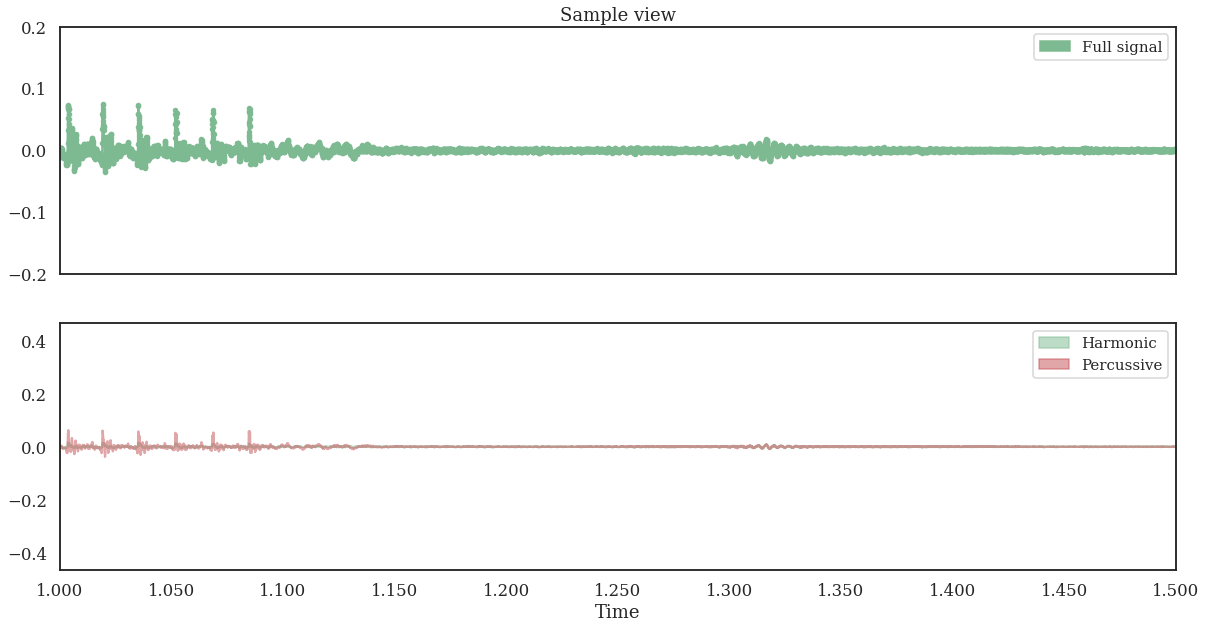

In [5]:
y_harm, y_perc = librosa.effects.hpss(sub_episode)

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize = (20,10))
ax.set(xlim=[1, 1.5], title='Sample view', ylim=[-0.2, 0.2])
librosa.display.waveshow(sub_episode, sr=sr, ax=ax, marker='.', label='Full signal')
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax2, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax2, label='Percussive')
ax.label_outer()
ax.legend(fontsize=15)
ax2.legend(fontsize=15)

In [6]:
df = pd.DataFrame()
df['time'] = time_stamp
df['original'] = sub_episode

In [7]:
df

,time,original
0,0.000000,-0.001871
1,0.000045,-0.000828
2,0.000091,0.001672
3,0.000136,0.001214
4,0.000181,-0.000078
...,...,...
12148987,550.974467,0.000000
12148988,550.974512,0.000000
12148989,550.974558,0.000000
12148990,550.974603,0.000000


Split original episode into time chunks of 551 individual data frames.

In [8]:
chunks = np.array_split(df, 551)

In [9]:
for i in chunks[:3]:
    print(i)
    print("==========")

           time  original
0      0.000000 -0.001871
1      0.000045 -0.000828
2      0.000091  0.001672
3      0.000136  0.001214
4      0.000181 -0.000078
...         ...       ...
22044  0.999728 -0.011750
22045  0.999773 -0.013681
22046  0.999819 -0.014028
22047  0.999864 -0.012122
22048  0.999909 -0.009752

[22049 rows x 2 columns]
           time  original
22049  0.999955 -0.007779
22050  1.000000 -0.005786
22051  1.000045 -0.004535
22052  1.000091 -0.004393
22053  1.000136 -0.002385
...         ...       ...
44093  1.999683  0.001659
44094  1.999728  0.000834
44095  1.999773  0.000284
44096  1.999819  0.000973
44097  1.999864  0.001298

[22049 rows x 2 columns]
           time  original
44098  1.999909  0.001681
44099  1.999955  0.001745
44100  2.000000  0.001001
44101  2.000045  0.001287
44102  2.000091  0.001302
...         ...       ...
66142  2.999637  0.072008
66143  2.999683  0.065108
66144  2.999728  0.058605
66145  2.999773  0.054437
66146  2.999819  0.042137

[22049 rows

In [10]:
chunks[0]

,time,original
0,0.000000,-0.001871
1,0.000045,-0.000828
2,0.000091,0.001672
3,0.000136,0.001214
4,0.000181,-0.000078
...,...,...
22044,0.999728,-0.011750
22045,0.999773,-0.013681
22046,0.999819,-0.014028
22047,0.999864,-0.012122


# Discrete Wavelet Transform (DWT)

The DWT is only discrete in the scale and translation domain, not in the time-domain. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

In [12]:
print(pywt.Modes.modes)
print(pywt.families())
print(pywt.families(short=False))

['zero', 'constant', 'symmetric', 'periodic', 'smooth', 'periodization', 'reflect', 'antisymmetric', 'antireflect']
['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


In [13]:
def dwt_transformation(chunks):
    cA_lst, cD_lst, y_lst = [], [], []
    for i in chunks:
        sample_episode = i.original
        t = np.arange(len(sample_episode))/float(sr) # getting time
        data = sample_episode/max(sample_episode) #normalize data
        
        # dwt transformation
        # Approximation and detail coefficients.
        cA, cD = pywt.dwt(data, 'db1', 'symmetric')
        cA_lst.append(cA)
        cD_lst.append(cD)
        
        # Inverse Discrete Wavelet Transform (IDWT)
        data_y = pywt.idwt(cA, cD, 'db1', 'symmetric')
        y_lst.append(data_y)
    
    return cA_lst, cD_lst, y_lst 

In [14]:
#y_lst

In [15]:
cA_lst, cD_lst, y_lst = dwt_transformation(chunks)

In [16]:
print(f"length of approximation coefficients cA_lst: {len(cA_lst)}")
print(f"length of detail coefficients cD_lst: {len(cD_lst)}")

print(f"length of each chunk's approximation coefficients in cA_lst: {len(cA_lst[0])}")
print(f"length of each chunk's detail coefficients cD_lst: {len(cD_lst[0])}")

print(f"length of each chunk's data points: {len(chunks[0])}")


length of approximation coefficients cA_lst: 551
length of detail coefficients cD_lst: 551
length of each chunk's approximation coefficients in cA_lst: 11025
length of each chunk's detail coefficients cD_lst: 11025
length of each chunk's data points: 22049


In [17]:
#cA_same_len = np.repeat(cA,2)
#cD_same_len = np.repeat(cD,2)

In [18]:
df = pd.DataFrame()
dwt_df = pd.DataFrame(cA_lst)
df['time_stamp'] = [np.mean(i.time) for i in chunks]

In [19]:
dwt_df

,0,1,2,3,4,5,6,7,8,9,...,11015,11016,11017,11018,11019,11020,11021,11022,11023,11024
0,-0.011694,0.012506,-0.006458,0.000520,-0.006922,-0.004735,-0.008048,-0.035831,-0.037008,-0.021307,...,0.161844,0.151945,0.104899,0.047014,-0.001519,-0.024888,-0.067175,-0.110195,-0.113315,-0.084517
1,-0.040582,-0.026707,-0.013360,-0.003045,0.012039,0.022075,0.012741,0.005375,0.014656,0.016028,...,-0.000938,-0.001297,0.003479,0.003342,0.005960,0.007244,0.010375,0.007459,0.003761,0.007765
2,0.007943,0.005302,0.005455,0.001315,-0.001884,-0.000847,-0.001727,-0.001001,-0.001029,0.001565,...,0.255481,0.319073,0.280425,0.247704,0.309629,0.371016,0.376685,0.317831,0.262028,0.195342
3,0.110209,0.040767,0.027741,-0.150003,-0.327989,-0.437009,-0.406879,-0.412253,-0.550497,-0.581232,...,-0.076862,0.020909,0.098463,0.252288,0.419103,0.556960,0.715029,0.876295,0.960228,0.996157
4,0.901836,0.925388,0.741316,0.445713,0.204743,-0.164705,-0.531868,-0.733800,-0.885932,-0.984427,...,0.136910,0.149971,0.214176,0.312498,0.348806,0.383572,0.405085,0.362960,0.368043,0.358280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,-0.085413,-0.183650,0.065039,0.235467,0.081745,-0.063696,0.161283,0.234052,-0.047524,-0.117947,...,0.274823,0.480472,0.600413,0.332748,0.057932,-0.042714,0.107018,0.360081,0.508064,NaN
547,0.424803,0.438531,0.650644,0.737199,0.737035,0.643570,0.333264,0.029115,-0.020705,0.026007,...,0.008734,0.044700,0.044853,0.154974,0.051651,0.054284,-0.051582,-0.116416,0.004906,NaN
548,0.588458,0.414509,0.005199,-0.836369,-0.032840,0.260368,-0.126350,0.370521,0.469937,0.373699,...,0.036567,0.001643,-0.023527,0.032986,0.113999,0.122568,0.060127,0.018880,0.015845,NaN
549,0.097844,0.176481,0.363965,0.296171,-0.118130,-0.112074,-0.156435,-0.437139,-0.657178,-0.576384,...,-0.001948,-0.001688,-0.000661,0.000215,0.001158,0.001797,0.003514,-0.000019,0.000316,NaN


In [20]:
df

,time_stamp
0,0.499955
1,1.499909
2,2.499864
3,3.499819
4,4.499773
...,...
546,546.475079
547,547.474989
548,548.474898
549,549.474807


In [21]:
result_df = pd.concat([df, dwt_df], axis=1)

In [22]:
result_df

,time_stamp,0,1,2,3,4,5,6,7,8,...,11015,11016,11017,11018,11019,11020,11021,11022,11023,11024
0,0.499955,-0.011694,0.012506,-0.006458,0.000520,-0.006922,-0.004735,-0.008048,-0.035831,-0.037008,...,0.161844,0.151945,0.104899,0.047014,-0.001519,-0.024888,-0.067175,-0.110195,-0.113315,-0.084517
1,1.499909,-0.040582,-0.026707,-0.013360,-0.003045,0.012039,0.022075,0.012741,0.005375,0.014656,...,-0.000938,-0.001297,0.003479,0.003342,0.005960,0.007244,0.010375,0.007459,0.003761,0.007765
2,2.499864,0.007943,0.005302,0.005455,0.001315,-0.001884,-0.000847,-0.001727,-0.001001,-0.001029,...,0.255481,0.319073,0.280425,0.247704,0.309629,0.371016,0.376685,0.317831,0.262028,0.195342
3,3.499819,0.110209,0.040767,0.027741,-0.150003,-0.327989,-0.437009,-0.406879,-0.412253,-0.550497,...,-0.076862,0.020909,0.098463,0.252288,0.419103,0.556960,0.715029,0.876295,0.960228,0.996157
4,4.499773,0.901836,0.925388,0.741316,0.445713,0.204743,-0.164705,-0.531868,-0.733800,-0.885932,...,0.136910,0.149971,0.214176,0.312498,0.348806,0.383572,0.405085,0.362960,0.368043,0.358280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,546.475079,-0.085413,-0.183650,0.065039,0.235467,0.081745,-0.063696,0.161283,0.234052,-0.047524,...,0.274823,0.480472,0.600413,0.332748,0.057932,-0.042714,0.107018,0.360081,0.508064,NaN
547,547.474989,0.424803,0.438531,0.650644,0.737199,0.737035,0.643570,0.333264,0.029115,-0.020705,...,0.008734,0.044700,0.044853,0.154974,0.051651,0.054284,-0.051582,-0.116416,0.004906,NaN
548,548.474898,0.588458,0.414509,0.005199,-0.836369,-0.032840,0.260368,-0.126350,0.370521,0.469937,...,0.036567,0.001643,-0.023527,0.032986,0.113999,0.122568,0.060127,0.018880,0.015845,NaN
549,549.474807,0.097844,0.176481,0.363965,0.296171,-0.118130,-0.112074,-0.156435,-0.437139,-0.657178,...,-0.001948,-0.001688,-0.000661,0.000215,0.001158,0.001797,0.003514,-0.000019,0.000316,NaN


# Logistic Regression on DWT Chunks

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve
from sklearn.utils import resample

In [24]:
union_disagree = pd.read_csv('union_annotation.csv')
union_disagree

,Unnamed: 0,annotator,text,label,start,end
0,0,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,8.653260,10.253415
1,1,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,14.367289,18.004163
2,2,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,28.312520,30.462509
3,3,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,31.612503,34.062490
4,4,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,43.356610,46.862424
5,5,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,59.062362,61.412350
6,6,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,62.952381,63.402378
7,7,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,67.958985,80.312252
8,8,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,80.669196,81.619288
9,9,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,91.712194,102.312139


In [25]:
def produce_label_y(start, end, timestamp):
    result = []
    for t in timestamp:
        flag = False
        for i,j in zip(start,end):
            if float(t)>=float(i) and float(t)<=float(j):
                result.append(1)
                flag = True
                break
            else:
                continue
        if not flag:
            result.append(0)
    return result

In [26]:
y_label = produce_label_y(union_disagree.start, union_disagree.end, result_df['time_stamp'])

Notes:
1. more features >> obs
2. data quality
3. selection of models

===
- treat coefficient as PCA terms (same idea of wavelets)
- overfit - use other models - Random forest


In [27]:
result_df['y'] = y_label
result_df = result_df.fillna(0)
result_df

,time_stamp,0,1,2,3,4,5,6,7,8,...,11016,11017,11018,11019,11020,11021,11022,11023,11024,y
0,0.499955,-0.011694,0.012506,-0.006458,0.000520,-0.006922,-0.004735,-0.008048,-0.035831,-0.037008,...,0.151945,0.104899,0.047014,-0.001519,-0.024888,-0.067175,-0.110195,-0.113315,-0.084517,0
1,1.499909,-0.040582,-0.026707,-0.013360,-0.003045,0.012039,0.022075,0.012741,0.005375,0.014656,...,-0.001297,0.003479,0.003342,0.005960,0.007244,0.010375,0.007459,0.003761,0.007765,0
2,2.499864,0.007943,0.005302,0.005455,0.001315,-0.001884,-0.000847,-0.001727,-0.001001,-0.001029,...,0.319073,0.280425,0.247704,0.309629,0.371016,0.376685,0.317831,0.262028,0.195342,0
3,3.499819,0.110209,0.040767,0.027741,-0.150003,-0.327989,-0.437009,-0.406879,-0.412253,-0.550497,...,0.020909,0.098463,0.252288,0.419103,0.556960,0.715029,0.876295,0.960228,0.996157,0
4,4.499773,0.901836,0.925388,0.741316,0.445713,0.204743,-0.164705,-0.531868,-0.733800,-0.885932,...,0.149971,0.214176,0.312498,0.348806,0.383572,0.405085,0.362960,0.368043,0.358280,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,546.475079,-0.085413,-0.183650,0.065039,0.235467,0.081745,-0.063696,0.161283,0.234052,-0.047524,...,0.480472,0.600413,0.332748,0.057932,-0.042714,0.107018,0.360081,0.508064,0.000000,0
547,547.474989,0.424803,0.438531,0.650644,0.737199,0.737035,0.643570,0.333264,0.029115,-0.020705,...,0.044700,0.044853,0.154974,0.051651,0.054284,-0.051582,-0.116416,0.004906,0.000000,0
548,548.474898,0.588458,0.414509,0.005199,-0.836369,-0.032840,0.260368,-0.126350,0.370521,0.469937,...,0.001643,-0.023527,0.032986,0.113999,0.122568,0.060127,0.018880,0.015845,0.000000,0
549,549.474807,0.097844,0.176481,0.363965,0.296171,-0.118130,-0.112074,-0.156435,-0.437139,-0.657178,...,-0.001688,-0.000661,0.000215,0.001158,0.001797,0.003514,-0.000019,0.000316,0.000000,0


time stamp (only) related for exploration:

In [28]:
X_time = result_df[result_df['time_stamp']<150]
y = result_df['y'].values[:150]
X_train, X_test, y_train, y_test = train_test_split(X_time, y, test_size=0.3, random_state=46)
logreg = LogisticRegression(penalty = 'l2', class_weight ='balanced', max_iter = 1e10)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000000000.0)

In [29]:
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob_log = logreg.predict_log_proba(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.90      0.76        29
           1       0.50      0.19      0.27        16

    accuracy                           0.64        45
   macro avg       0.58      0.54      0.52        45
weighted avg       0.61      0.64      0.59        45



Logistic Regression dropping y and timestamp, with only dwt

In [31]:
X = result_df.drop(columns=['y','time_stamp']).values[:250]
#X = result_df.drop(columns=['y']).values
y = result_df['y'].values[:250]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=46)
logreg = LogisticRegression(penalty = 'l2', class_weight ='balanced', max_iter = 1e10)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000000000.0)

In [33]:
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob_log = logreg.predict_log_proba(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.57


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        47
           1       0.33      0.14      0.20        28

    accuracy                           0.57        75
   macro avg       0.48      0.49      0.45        75
weighted avg       0.51      0.57      0.52        75



In [35]:
print(confusion_matrix(y_test, y_pred))

[[39  8]
 [24  4]]


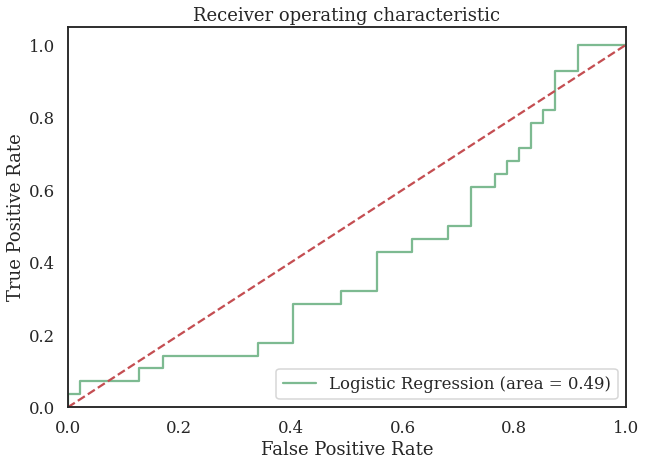

In [36]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Taking a look at y prediction exact probability, does not seem to have special pattern.

In [37]:
pred_result_df = pd.DataFrame(y_pred_prob)
pred_result_df['y_pred'] = y_pred
pred_result_df['y_pred_true_label'] = y_test

display(pred_result_df)

,0,1,y_pred,y_pred_true_label
0,0.955850,0.044150,0,1
1,0.625287,0.374713,0,0
2,0.977627,0.022373,0,1
3,0.807267,0.192733,0,1
4,0.679897,0.320103,0,0
...,...,...,...,...
70,0.951258,0.048742,0,0
71,0.999769,0.000231,0,0
72,0.463594,0.536406,1,0
73,0.654541,0.345459,0,0


In [38]:
pred_result_df[pred_result_df['y_pred'] == 0]

,0,1,y_pred,y_pred_true_label
0,0.955850,0.044150,0,1
1,0.625287,0.374713,0,0
2,0.977627,0.022373,0,1
3,0.807267,0.192733,0,1
4,0.679897,0.320103,0,0
...,...,...,...,...
67,0.754650,0.245350,0,0
70,0.951258,0.048742,0,0
71,0.999769,0.000231,0,0
73,0.654541,0.345459,0,0


In [39]:
pred_result_df[pred_result_df['y_pred'] == 1]

,0,1,y_pred,y_pred_true_label
6,0.365466,0.634534,1,0
12,0.481052,0.518948,1,0
13,0.336470,0.663530,1,0
33,0.425067,0.574933,1,0
37,0.489602,0.510398,1,1
50,0.159419,0.840581,1,1
55,0.430837,0.569163,1,0
60,0.113663,0.886337,1,0
61,0.044034,0.955966,1,1
68,0.441885,0.558115,1,1


In [40]:
# false negative
pred_result_df[(pred_result_df['y_pred'] == 0) & (pred_result_df['y_pred_true_label'] == 1)]

,0,1,y_pred,y_pred_true_label
0,0.955850,0.044150,0,1
2,0.977627,0.022373,0,1
3,0.807267,0.192733,0,1
8,0.890569,0.109431,0,1
10,0.966478,0.033522,0,1
11,0.814765,0.185235,0,1
15,0.868522,0.131478,0,1
17,0.886707,0.113293,0,1
19,0.928705,0.071295,0,1
22,0.945756,0.054244,0,1


In [41]:
# false positive
pred_result_df[(pred_result_df['y_pred'] == 1) & (pred_result_df['y_pred_true_label'] == 0)]

,0,1,y_pred,y_pred_true_label
6,0.365466,0.634534,1,0
12,0.481052,0.518948,1,0
13,0.336470,0.663530,1,0
33,0.425067,0.574933,1,0
55,0.430837,0.569163,1,0
60,0.113663,0.886337,1,0
69,0.407268,0.592732,1,0
72,0.463594,0.536406,1,0


# Random Forest & AdaBoost

In [42]:
rmf = RandomForestClassifier(random_state = 34)
rmf.fit(X_train, y_train)

y_pred_rmf = rmf.predict(X_test)
y_pred_prob_rmf = rmf.predict_proba(X_test)
y_pred_prob_log_rmf = rmf.predict_log_proba(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(rmf.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.65


In [43]:
print(classification_report(y_test, y_pred_rmf))

              precision    recall  f1-score   support

           0       0.67      0.87      0.76        47
           1       0.57      0.29      0.38        28

    accuracy                           0.65        75
   macro avg       0.62      0.58      0.57        75
weighted avg       0.63      0.65      0.62        75



In [44]:
print(confusion_matrix(y_test, y_pred_rmf))

[[41  6]
 [20  8]]


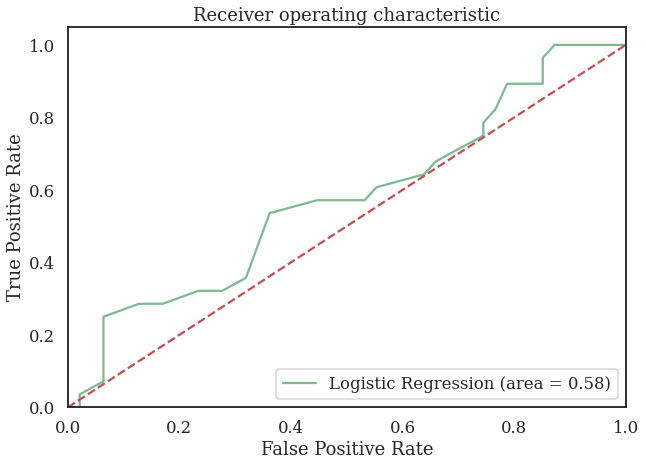

In [45]:
rmf_roc_auc = roc_auc_score(y_test, rmf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rmf.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rmf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [46]:
# Initialise the model with Decision Tree classifier as the base model
boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), 
                            algorithm = 'SAMME.R', learning_rate=1,random_state = 10)

# Fit on the entire data
boost.fit(X_train,y_train)

y_pred_boost = boost.predict(X_test)
y_pred_prob_boost = boost.predict_proba(X_test)
y_pred_prob_log_boost = boost.predict_log_proba(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(boost.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.56


In [47]:
print(classification_report(y_test, y_pred_boost))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62        47
           1       0.43      0.54      0.48        28

    accuracy                           0.56        75
   macro avg       0.55      0.56      0.55        75
weighted avg       0.58      0.56      0.57        75



In [48]:
print(confusion_matrix(y_test, y_pred_boost))

[[27 20]
 [13 15]]


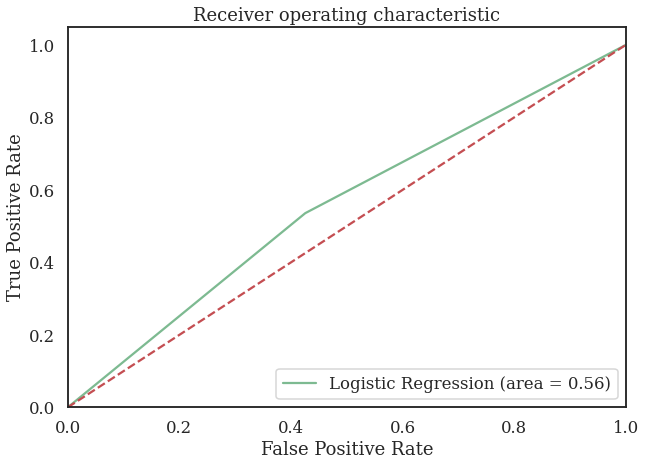

In [49]:
boost_roc_auc = roc_auc_score(y_test, boost.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, boost.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % boost_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Audio Augmentation

In [50]:
# %pip install audiomentations
# %pip install pydub

In [51]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

SAMPLE_RATE = 16000

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

/Users/jiahuitang/opt/anaconda3/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [52]:
augmented_samples = augment(samples=sub_episode, sample_rate=sr)

In [53]:
len(augmented_samples)

12148992

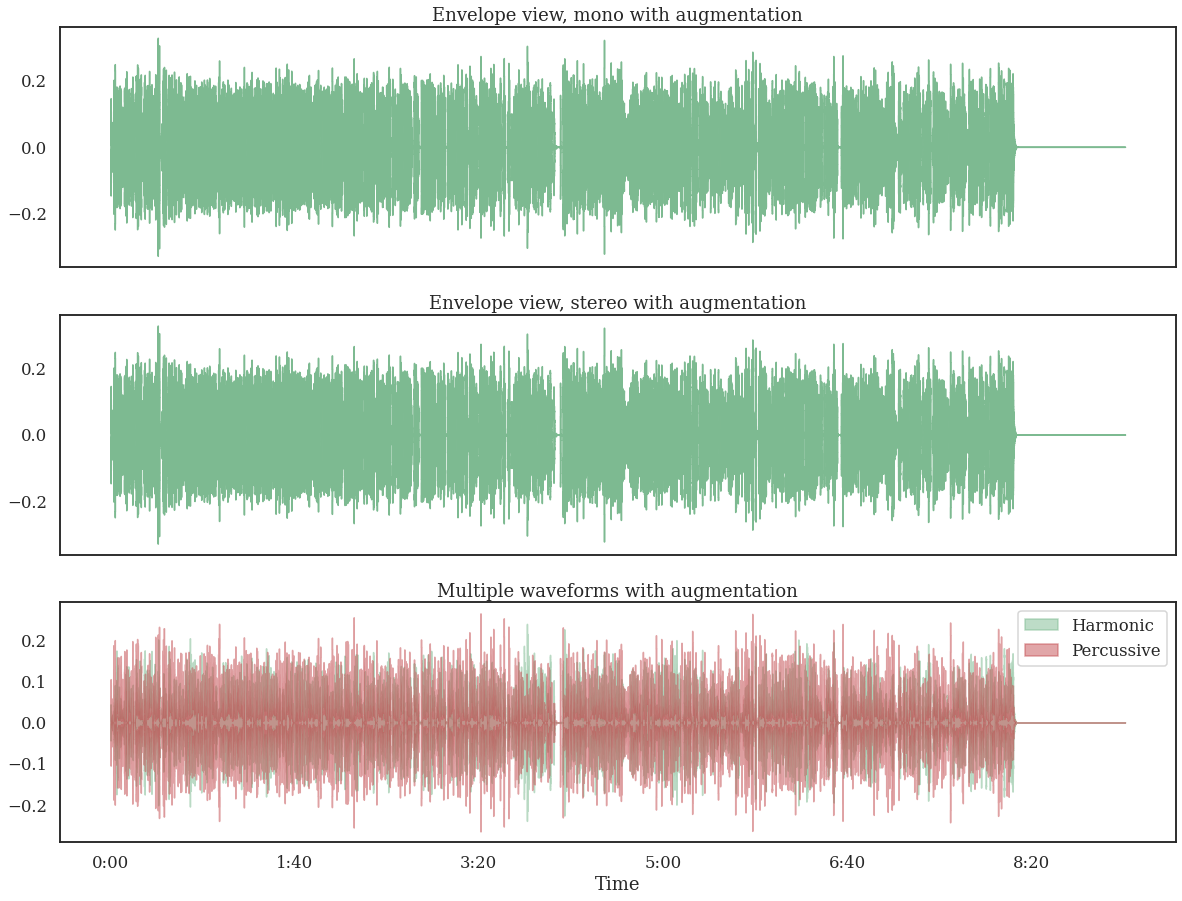

In [54]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize = (20,15))
librosa.display.waveshow(augmented_samples, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view, mono with augmentation')
ax[0].label_outer()

librosa.display.waveshow(augmented_samples, sr=sr, ax=ax[1])
ax[1].set(title='Envelope view, stereo with augmentation')
ax[1].label_outer()

y_harm, y_perc = librosa.effects.hpss(augmented_samples)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')
ax[2].set(title='Multiple waveforms with augmentation')
ax[2].legend()

comparing with original graph without augmentation

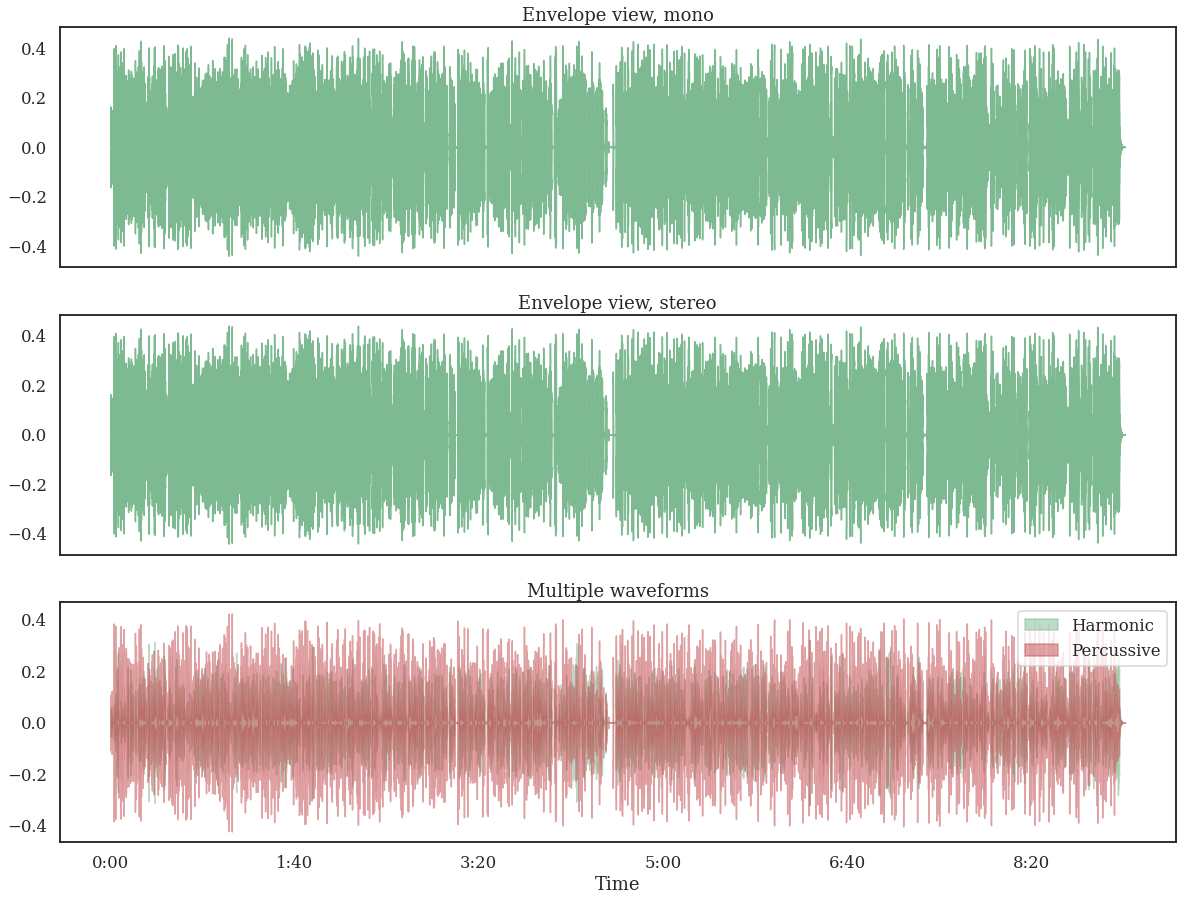

In [55]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize = (20,15))
librosa.display.waveshow(sub_episode, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()

librosa.display.waveshow(sub_episode, sr=sr, ax=ax[1])
ax[1].set(title='Envelope view, stereo')
ax[1].label_outer()

y_harm, y_perc = librosa.effects.hpss(sub_episode)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')
ax[2].set(title='Multiple waveforms')
ax[2].legend()